In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Monte Carlo approximation of the Greeks

In [2]:
# Global variables

r = .02
sigma = .4
S0 = 100
T = .9
n = 1000

Ks = np.arange(80, 121)
Ms = [100, 500, 1000, 2000, 5000, 10000]
M = 1000

We assume we are under the Black-Scholes context:

$$
dS_{t} = S_{t}(rdt + \sigma dB_{t})
$$

Hence:

$$
S_{t} = S_{0} e^{(r - \frac{\sigma^{2}}{2}) t + \sigma B_{t}}
$$

In this notebook we are interested in the approximation of the no arbitrage price of an option with payoff $\mathbf{1}_{S_{T}\leq K}$. The optimal hedging strategy leads to:

$$
C_{0} = e^{-rT} \mathbb{E}[\mathbf{1}_{S_{T}\leq K}] = e^{rT} \mathbf{N}(-d_{-}(X_{0}, \sigma^{2}T))
$$

$$
\Delta_{0} = e^{-rT} \frac{\partial}{\partial S_{0}}\mathbb{E}[\mathbf{1}_{S_{T}\leq K}] = \frac{e^{-rT}}{S_{0}\sqrt{\sigma^{2}T}} \mathbf{N}^{\prime}(-d_{-}(X_{0}, \sigma^{2}T)) 
$$

## Exercise 1.a

In [3]:
## Exercise 1.a

def d_minus(x: float, v: float) -> float:
    return np.log(x) / np.sqrt(v) - (1/2) * np.sqrt(v)

def c0(r: float, sigma: float, S0: float, T: float, K: float) -> float:
    ''' Computes price C0 of option
    '''
    X0 = S0 / (K * np.exp(-r*T))
    return np.exp(-r*T) * scipy.stats.norm.cdf(-d_minus(X0, T*sigma**2))

def delta0(r: float, sigma: float, S0: float, T: float, K: float) -> float:
    ''' Computes Delta0 of option
    '''
    X0 = S0 / (K * np.exp(-r*T))
    return - (np.exp(-r*T) / (S0 * np.sqrt(T*sigma**2))) * scipy.stats.norm.pdf(-d_minus(X0, T*sigma**2))

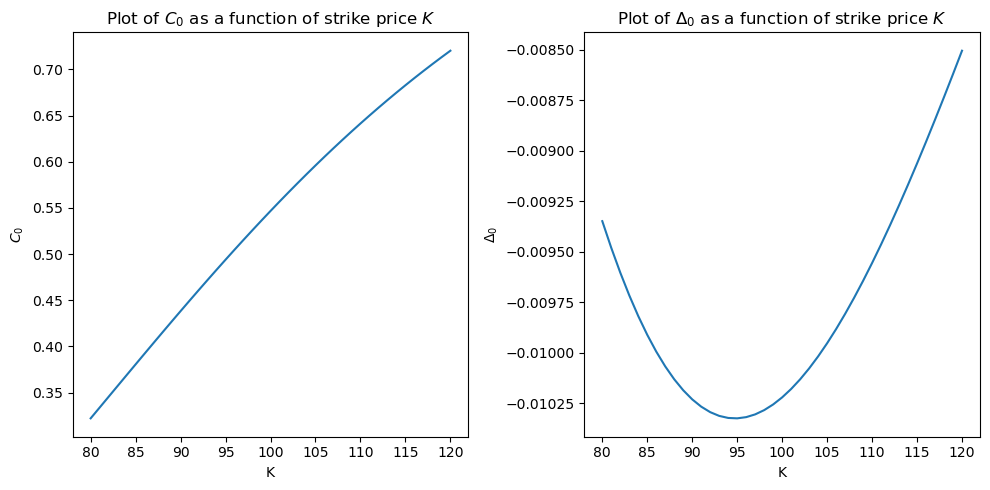

In [4]:
# Visualizing theoretical curves

Vc0 = np.vectorize(lambda x : c0(r, sigma, S0, T, x))
theoretical_c0 = Vc0(Ks)

Vdelta0 = np.vectorize(lambda x : delta0(r, sigma, S0, T, x))
theoretical_delta0 = Vdelta0(Ks)

# Plotting theoretical price of option C_0
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)  # Subplot for C_0

plt.plot(Ks, theoretical_c0)
plt.title("Plot of $C_{0}$ as a function of strike price $K$")
plt.xlabel('K')
plt.ylabel('$C_{0}$')

# Plotting theoretical delta_0
plt.subplot(1, 2, 2)  # Subplot for delta_0

plt.plot(Ks, theoretical_delta0)
plt.title("Plot of $\Delta_{0}$ as a function of strike price $K$")
plt.xlabel('K')
plt.ylabel('$\Delta_{0}$')

plt.tight_layout()
plt.show()

## Exercise 1.b

Here we only require the last value of $S$ under the Black Scholes model:

$$
S_{t} = S_{0} e^{(r - \frac{\sigma^{2}}{2}) t + \sigma B_{t}}
$$

Furthermore, based on the theoretical expression, the Monte Carlo estimator that we can use is:

$$
C_{0}^{M} = \frac{1}{M} e^{-rT} \sum_{i = 1}^{M}\mathbf{1}_{S_{T}\leq K}
$$

For estimating a confidence interval of $5\%$ of our results, we will use the asymptotical approximation:

$$
\Delta_{I} = 1.96 \frac{\sigma}{\sqrt{M}}
$$

In [5]:
# Implementing monte carlo simulation function
def monte_carlo_simulation_c(r: float, sigma: float, S0: float, T: float, M: int, K: float):
    ''' Monte-Carlo implementation using exact expression of Black-Scholes model 
    '''
    B = np.random.normal(0, np.sqrt(T), (M,1))
    S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * B)
    
    c0 = np.exp(-r*T) * (1.0 * (S[:,-1] <= K))
    
    
    c0_mean = c0.mean()
    c0_std = c0.std()
    
    return c0_mean, c0_std

In [6]:
# First visualizion of the Monte Carlo simulation
Vmontecarlo_simulation = np.vectorize(lambda x : monte_carlo_simulation_c(r, sigma, S0, T, 100, x))
mc, _ = Vmontecarlo_simulation(Ks)

print(f"Example when fixing M=100")
print(mc)
print()

Vmontecarlo_simulation = np.vectorize(lambda x : monte_carlo_simulation_c(r, sigma, S0, T, 2000, x))
mc, _ = Vmontecarlo_simulation(Ks)

print(f"Example when fixing M=2000")
print()
print("Monte Carlo simulation:")
print(mc)

print()
print("Theoretical values:")
print(theoretical_c0)

Example when fixing M=100
[0.31429153 0.40268602 0.32411314 0.33393475 0.35357797 0.44197246
 0.41250763 0.40268602 0.50090213 0.37322119 0.36339958 0.41250763
 0.49108052 0.39286441 0.55001018 0.45179407 0.5696534  0.49108052
 0.59911823 0.52054535 0.53036696 0.59911823 0.57947501 0.5696534
 0.61876145 0.55001018 0.62858306 0.55001018 0.64822628 0.72679916
 0.62858306 0.67769111 0.73662077 0.71697755 0.64822628 0.69733433
 0.69733433 0.65804789 0.69733433 0.70715594 0.70715594]

Example when fixing M=2000

Monte Carlo simulation:
[0.31674693 0.32804178 0.34424744 0.35210473 0.38107848 0.3958109
 0.38598929 0.39237333 0.40661467 0.41005223 0.45572272 0.46701757
 0.46996405 0.46407109 0.51072374 0.48911619 0.5166167  0.52987588
 0.52201859 0.51808994 0.53625992 0.57063556 0.5745642  0.59175202
 0.59371634 0.60893984 0.59617175 0.61139524 0.62269009 0.6300563
 0.6325117  0.6276009  0.64724412 0.65411925 0.67278031 0.67818219
 0.70912027 0.6880038  0.72483484 0.69929866 0.72532592]

Theor

We see that Monte Carlo simulations agree with theoretical values. On top of that, the larget $M$ is, the closer we get to them.

## Exercise 1.c

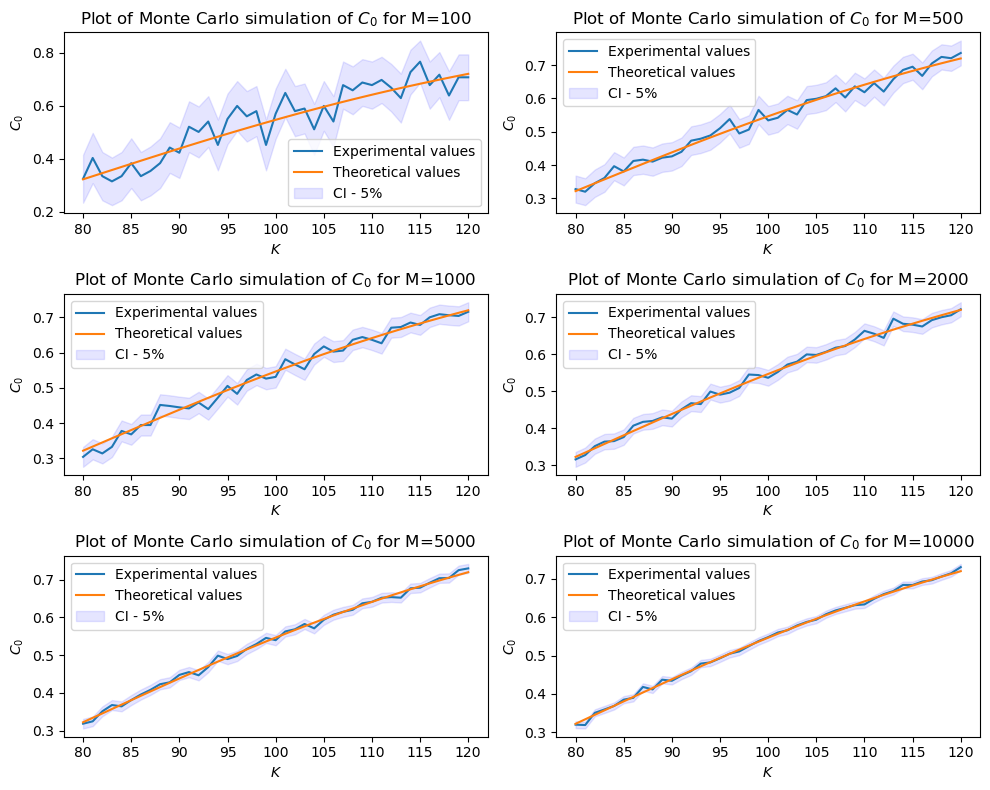

In [7]:
# Generating simulations
mc_means = dict()
mc_stds = dict()

for M in Ms:
    Vmontecarlo_simulation = np.vectorize(lambda x : monte_carlo_simulation_c(r, sigma, S0, T, M, x))
    mc_mean, mc_std = Vmontecarlo_simulation(Ks)
    
    mc_means[M] = mc_mean
    mc_stds[M] = mc_std
    
# Plotting simulations

fig, axes = plt.subplots(3, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, (M, mc) in enumerate(mc_means.items()):
    ax = axes[idx]
    confidence_interval = mc_stds[M] * 1.96 / np.sqrt(M)
    
    ax.plot(Ks, mc, label='Experimental values')
    ax.plot(Ks, theoretical_c0, label='Theoretical values')
    ax.fill_between(Ks, mc - confidence_interval, mc + confidence_interval, color = 'blue', alpha = 0.1, label = 'CI - 5%')
    ax.set_title(f'Plot of Monte Carlo simulation of $C_{0}$ for M={M}')
    ax.set_ylabel('$C_{0}$')
    ax.set_xlabel('$K$')
    ax.legend()

plt.tight_layout()
plt.show()

We can see that our Monte Carlo simulations fit really well the theoretical values for $C_{0}$. As expected, the larger is the number of simulations $M$, the closer we get to the theoretical value. 

We can confirm experimentally this observation by looking at the Mean Absolute Error of each of our Monte Carlo simulations with respect to the theoretical curve.

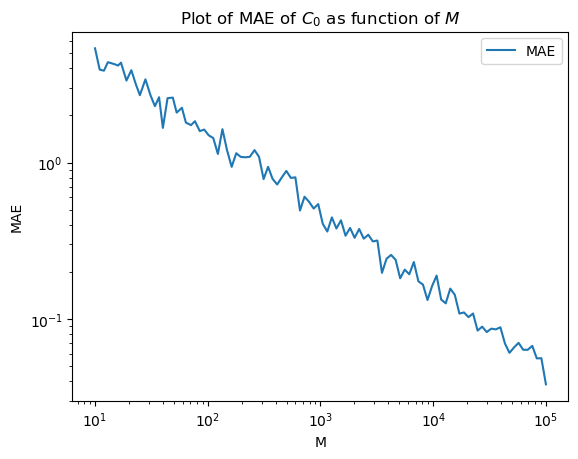

In [8]:
Ms_exp = np.geomspace(10, int(1e5), num=100)
Ms_exp = np.round(Ms_exp).astype(int) 

# Generating simulations
err = []

for M in Ms_exp:
    Vmontecarlo_simulation = np.vectorize(lambda x : monte_carlo_simulation_c(r, sigma, S0, T, M, x))
    mc_mean, _ = Vmontecarlo_simulation(Ks)

    err.append(np.sum(np.abs(mc_mean - theoretical_c0)))

# Plotting simulations for M = 1000
plt.plot(Ms_exp, err, label='MAE')
plt.title(f"Plot of MAE of $C_{0}$ as function of $M$")


plt.xlabel('M')
plt.ylabel('MAE')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Exercise 2

## Exercise 2.a

For the confidence interval of $\alpha = 5\%$ we will use the asymptotical approximation:

$$
\Delta_{I} = 1.96 \frac{\sigma}{\sqrt{M}}
$$

Below we plot an example for $\epsilon = 0.5$, which we will later verify experimentally that corresponds to the optimal value.

In [9]:
def delta_finite_diff(r: float, sigma: float, S0: float, T: float, M: int, K: float, eps: float):
    ''' Returns delta0 for finite-differences approximation with its corresponding standard
    deviation.
    '''
    B = np.random.normal(0, np.sqrt(T), (M,1))
    S_minus = (S0 - eps) * np.exp((r - 0.5 * sigma**2) * T + sigma * B)
    S_plus = (S0 + eps) * np.exp((r - 0.5 * sigma**2) * T + sigma * B)
    
    delta0 = np.exp(-r*T) * (1.0*(S_plus[:,-1] <= K) - 1.0*(S_minus[:,-1] <= K))
    
    return delta0.mean(), delta0.std()

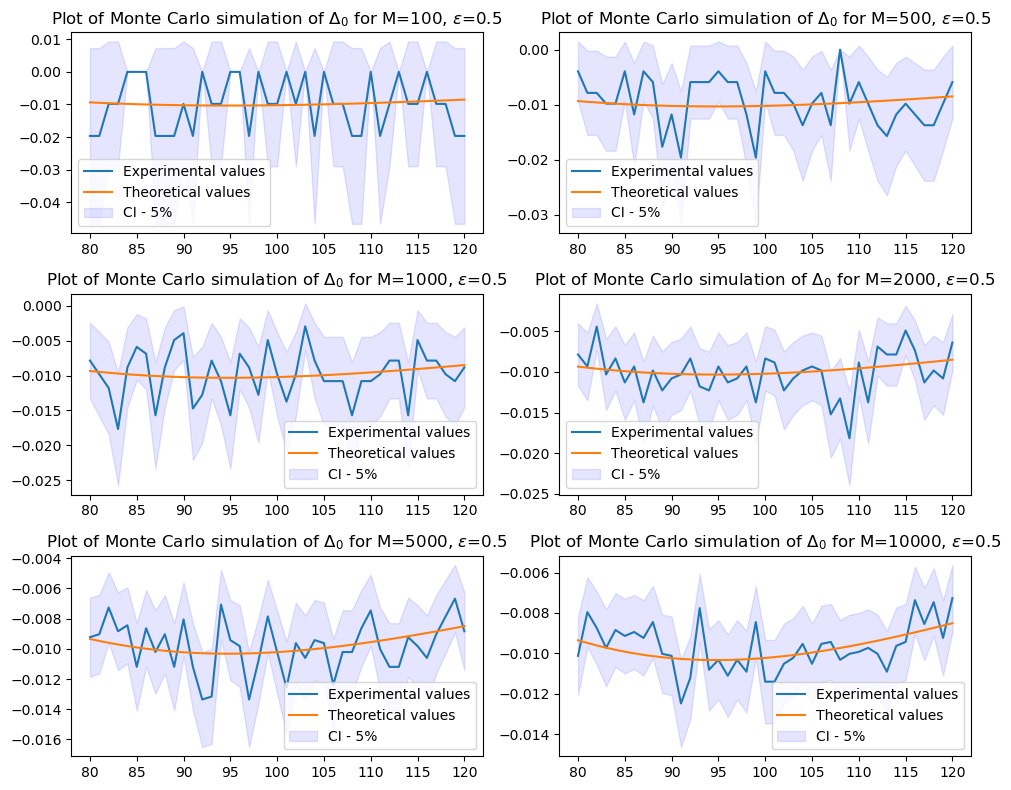

In [10]:
# Generating simulations
mcs_delta_means = dict()
mcs_delta_confidence_interval = dict()
eps = 0.5

for M in Ms:
    Vdelta_finite_diff = np.vectorize(lambda x : delta_finite_diff(r, sigma, S0, T, M, x, eps))
    mc_delta_mean, mc_delta_std = Vdelta_finite_diff(Ks)
    
    mcs_delta_means[M] = mc_delta_mean
    mcs_delta_confidence_interval[M] = mc_delta_std * 1.96 / np.sqrt(M)
    
# Plotting simulations
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, (M, mc) in enumerate(mcs_delta_means.items()):
    ax = axes[idx]
    confidence_interval = mcs_delta_confidence_interval[M]
    
    ax.plot(Ks, mc, label='Experimental values')
    ax.plot(Ks, theoretical_delta0, label='Theoretical values')
    ax.fill_between(Ks, mc - confidence_interval, mc + confidence_interval, color = 'blue', alpha = 0.1, label = 'CI - 5%')
    ax.set_title(f'Plot of Monte Carlo simulation of $\Delta_{0}$ for M={M}, $\epsilon$={eps}')
    ax.legend()

plt.tight_layout()
plt.show()

We remark that the fit of our Monte Carlo simulations improve significantly with $M$.

## Exercise 2.b

In theory, the larger the value of $M$ is, the better precision we will get as we observed that we get better estimator for $C_{0}$. This was also observed for the example in 2.a. As for the value of $\epsilon$, altough intuitively one may think that the smaller it is the better, we must verify experimentally if it is indeed the case.

Let us first observe how the Monte Carlo simulation fit the theoretical curve for some values of $\epsilon$.

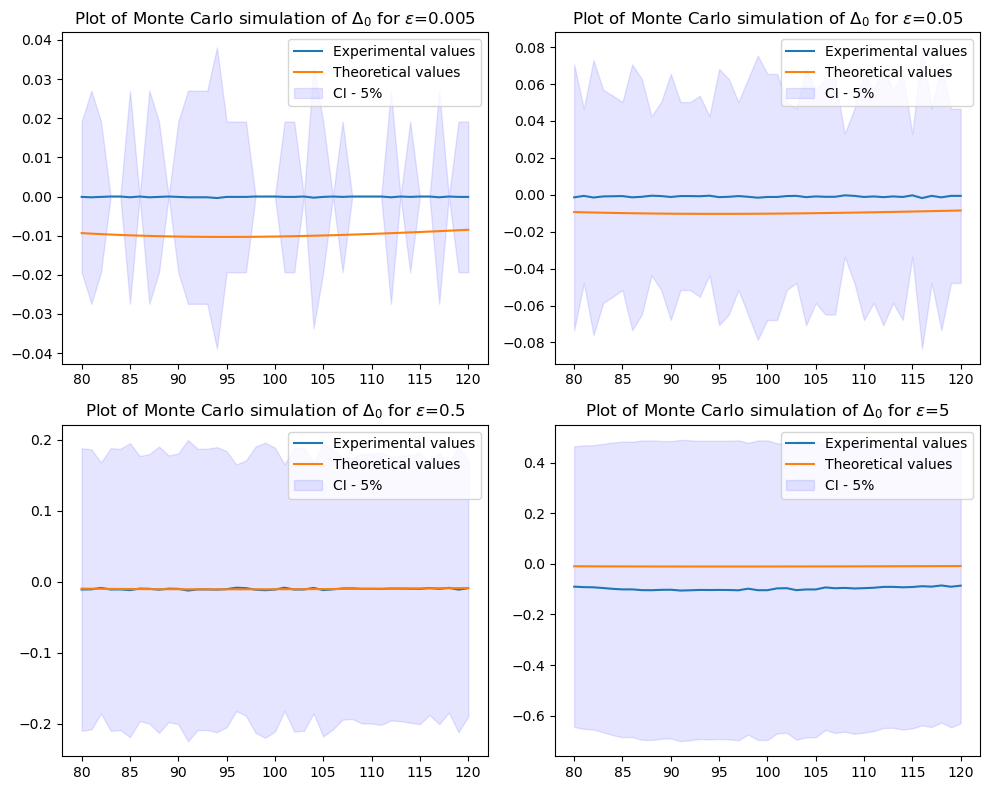

In [11]:
M = 10000
epss = [0.005, .05, .5, 5]

# Generating simulations
mcs_delta_means = dict()
mcs_delta_confidence_interval = dict()

for eps in epss:
    Vdelta_finite_diff = np.vectorize(lambda x : delta_finite_diff(r, sigma, S0, T, M, x, eps))
    mc_delta_mean, mc_delta_std = Vdelta_finite_diff(Ks)
    
    mcs_delta_means[eps] = mc_delta_mean
    mcs_delta_confidence_interval[eps] = mc_delta_std * 1.96
    
# Plotting simulations
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, (eps, mc) in enumerate(mcs_delta_means.items()):
    ax = axes[idx]
    confidence_interval = mcs_delta_confidence_interval[eps]
    
    ax.plot(Ks, mc, label='Experimental values')
    ax.plot(Ks, theoretical_delta0, label='Theoretical values')
    ax.fill_between(Ks, mc - confidence_interval, mc + confidence_interval, color = 'blue', alpha = 0.1, label = 'CI - 5%')
    ax.set_title(f'Plot of Monte Carlo simulation of $\Delta_{0}$ for $\epsilon$={eps}')
    ax.legend()

plt.tight_layout()
plt.show()

We see that it seems that there is an optimal value of $\epsilon$ close to 0.5. To make sure we extract the best one, we will study the Mean Absolute Error (MAE) of our simulations for different values of $\epsilon$ in an attempt to find the best solution.

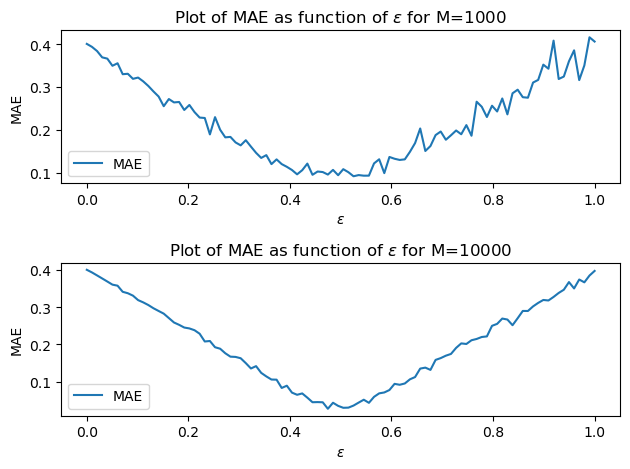

In [12]:
# First plot for M = 1000
M = 1000
epss = np.linspace(0, 1, 100)

# Generating simulations
err = []

for eps in epss:
    Vdelta_finite_diff = np.vectorize(lambda x: delta_finite_diff(r, sigma, S0, T, M, x, eps))
    mc_delta_mean, _ = Vdelta_finite_diff(Ks)

    err.append(np.sum(np.abs(mc_delta_mean - theoretical_delta0)))

# Plotting simulations for M = 1000
plt.subplot(2, 1, 1)
plt.plot(epss, err, label='MAE')
plt.title(f"Plot of MAE as function of $\epsilon$ for {M=}")
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('MAE')

# Second plot for M = 1000
M = 10000
epss = np.linspace(0, 1, 100)

# Generating simulations
err = []

for eps in epss:
    Vdelta_finite_diff = np.vectorize(lambda x: delta_finite_diff(r, sigma, S0, T, M, x, eps))
    mc_delta_mean, _ = Vdelta_finite_diff(Ks)

    err.append(np.sum(np.abs(mc_delta_mean - theoretical_delta0)))

# Plotting simulations for M = 10000
plt.subplot(2, 1, 2)
plt.plot(epss, err, label='MAE')
plt.title(f"Plot of MAE as function of $\epsilon$ for {M=}")
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('MAE')

plt.tight_layout()

plt.show()

We observe experimentally that indeed the best value for $\epsilon$ is $\epsilon^{\star} = 0.5$.

Furthermore, if we wanted to certify our intuition for the larget value of $M$ yielding better results we could run a similar study. We compute the MAE for different values of $M$ and observe its evolution.

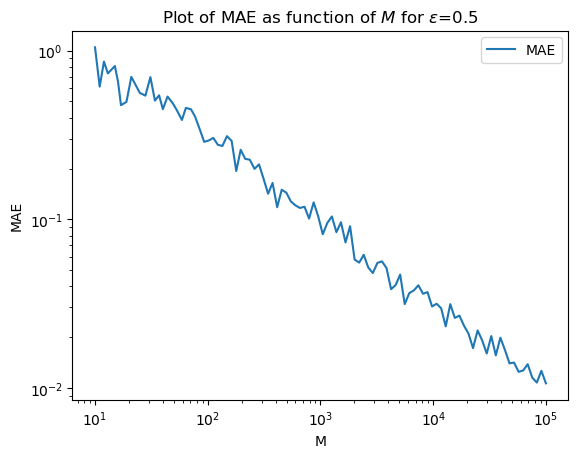

In [13]:
# First plot for M = 1000
Ms_exp = np.geomspace(10, int(1e5), num=100)
Ms_exp = np.round(Ms_exp).astype(int) 
eps = .5 

# Generating simulations
err = []

for M in Ms_exp:
    Vdelta_finite_diff = np.vectorize(lambda x: delta_finite_diff(r, sigma, S0, T, M, x, eps))
    mc_delta_mean, _ = Vdelta_finite_diff(Ks)

    err.append(np.sum(np.abs(mc_delta_mean - theoretical_delta0)))

# Plotting simulations for M = 1000
plt.plot(Ms_exp, err, label='MAE')
plt.title(f"Plot of MAE as function of $M$ for $\epsilon$={eps}")


plt.xlabel('M')
plt.ylabel('MAE')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

The study confirms our intuition.

We have therefore the the bigger M is the better and the best choice of $\epsilon$ is $\epsilon^{\star} = 0.5$. One most keep in mind however that by increasing $M$ it will take longer for our simulations to run.

# Exercise 3

## Exercise 3.a

Given that:
    
$$
\Delta_{0} = e^{-rT} \mathbb{E}\left[\mathbf{1}_{S_{T} \leq K} \frac{B_{T}}{S_{0}\sigma T}\right]
$$

A natural estimator would be:

$$
\hat\Delta^{M}_{0} = \frac{1}{M} e^{-rT} \sum_{i = 1}^{M} \mathbf{1}_{S_{T,i}\leq K} \frac{B_{T,i}}{S_{0}\sigma T}
$$

Where each $S_{T,i}$ and $B_{T,i}$ correspond to a simulation.

In [14]:
# Implementing monte carlo simulation function
def monte_carlo_simulation_delta(r: float, sigma: float, S0: float, T: float, n: int, M: int, K: float):
    
    B = np.random.normal(0, np.sqrt(T), (M,1))
    S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * B)
    
    delta0 = np.exp(-r*T) * (1.0 * (S <= K) * B / (S0 * sigma * T)) 
    
    delta0_mean = np.mean(delta0)
    delta0_std = np.std(delta0)
    
    return delta0_mean, delta0_std

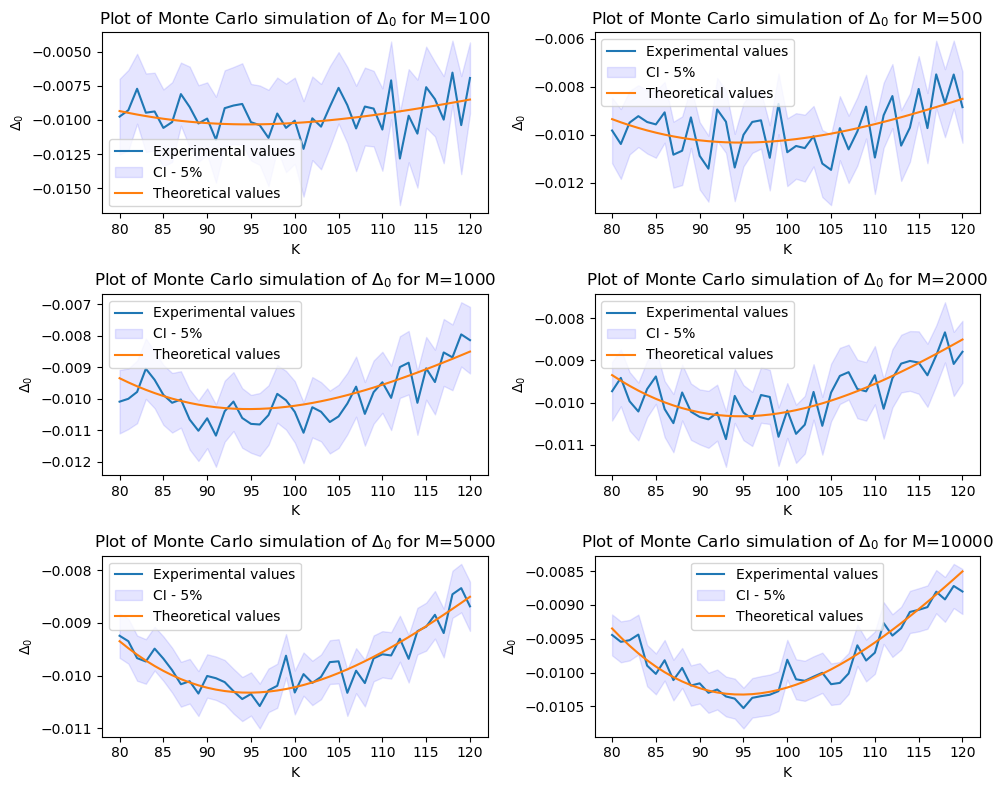

In [15]:
# Generating simulations
mc_delta_means = dict()
mc_delta_stds = dict()

for M in Ms:
    Vmontecarlo_simulation = np.vectorize(lambda x : monte_carlo_simulation_delta(r, sigma, S0, T, n, M, x))
    mc_delta_mean, mc_delta_std = Vmontecarlo_simulation(Ks)
    
    mc_delta_means[M] = mc_delta_mean
    mc_delta_stds[M] = mc_delta_std
    
# Plotting simulations
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, (M, mc_delta) in enumerate(mc_delta_means.items()):
    ax = axes[idx]
    
    confidence_interval = mc_delta_stds[M] * 1.96 / np.sqrt(M)
    
    ax.plot(Ks, mc_delta, label='Experimental values')
    ax.fill_between(Ks, mc_delta - confidence_interval, mc_delta + confidence_interval, color = 'blue', alpha = 0.1, label = 'CI - 5%')
    ax.plot(Ks, theoretical_delta0, label='Theoretical values')
    ax.set_title(f'Plot of Monte Carlo simulation of $\Delta_{0}$ for M={M}')
    ax.set_xlabel('K')
    ax.set_ylabel('$\Delta_{0}$')
    ax.legend()

plt.tight_layout()
plt.show()

We see that our Monte Carlo simulation fits really well the theoretical curve. Since for even small values of $M$ we already see a better fit than our previous method, we have strong indications that this is a better method for simulating $\Delta_{0}$.

## Exercise 3.b

To compare the performance of both estimators, we can make use once again the MAE for different values of $M$ and see their error.

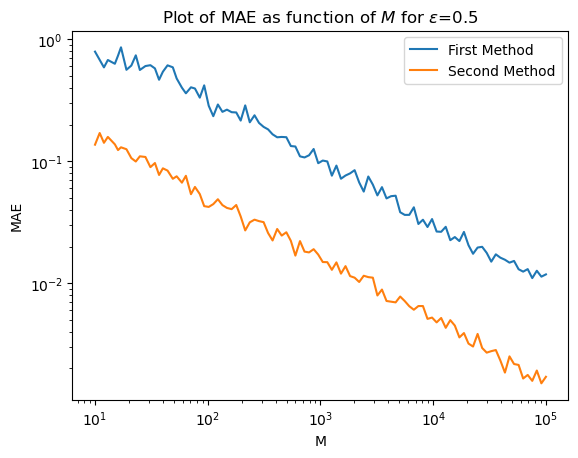

In [16]:
Ms_exp = np.geomspace(10, int(1e5), num=100)
Ms_exp = np.round(Ms_exp).astype(int) 
eps = .5 

# Generating simulations
err_first = []
err_second = []

for M in Ms_exp:
    # First (Difference) estimator
    Vdelta_finite_diff = np.vectorize(lambda x: delta_finite_diff(r, sigma, S0, T, M, x, eps))
    mc_delta_first, _ = Vdelta_finite_diff(Ks)
    
    err_first.append(np.sum(np.abs(mc_delta_first - theoretical_delta0)))
    
    # Second estimator
    Vmontecarlo_simulation = np.vectorize(lambda x : monte_carlo_simulation_delta(r, sigma, S0, T, n, M, x))
    mc_delta_second, _ = Vmontecarlo_simulation(Ks)
    
    err_second.append(np.sum(np.abs(mc_delta_second - theoretical_delta0)))

# Plotting simulations for M = 1000
plt.plot(Ms_exp, err_first, label='First Method')
plt.plot(Ms_exp, err_second, label='Second Method')
plt.title(f"Plot of MAE as function of $M$ for $\epsilon$={eps}")


plt.xlabel('M')
plt.ylabel('MAE')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

The study confirms our intuition from the previous exercise. We see that both estimators share the same order of convergence, however the second one has a better constant factor, approximating better our Greek $\Delta_{0}$.